<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='../../pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='../../pics/miw.PNG'/></a>
</div>
</a>

# Practicum Convolution Neural Nets (CNN) Deel 1

**Doel: Toepassen Convolutional Neural Networks**

### Imports

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

<h3>Globale variabelen</h3>

In [22]:
forestDirectory = '../../pics/2750/River'
industrialDirectory = '../../pics/2750/Industrial'

### Context

<p>
Dit practicum bestaat uit twee onderdelen
<ol>
    <li>Het toepassen van een convolutie en pooling filter</li>
    <li>Het bouwen en trainen van een eenvoudig convolutional neural net dat een industrieterrein van een bos kan onderscheiden. Voor beide oefeningen gebruiken we de EuroSAT_RGB dataset</li>
</p>

<img src='../../pics/eurosat_cnn.png' length=65% width=65%>

<h3>Data Collection</h3>
<p>
We gebruiken Images uit de <a href="https://github.com/phelber/EuroSAT">EuroSat dataset</a> die gemaakt zijn met de Sentinel-2 sateliet. Elke image is een 64x64 pixels foto van Europees aardoppervlak op een hoogte van 10 meter. De images zijn te categoriseren in Highway, Industrial, Pasture, PermanentCrop, Residential, River en SeaLake.
</p>
<img src=../../pics/eurosat_overview_small.jpg length=40% width=40%>
<p>
Download <a href="http://madm.dfki.de/files/sentinel/EuroSAT.zip">EuroSAT.zip</a> en kopieer daaruit de directory 2750 naar opdrachten/practica/pics.      
<strong>Voeg het pad naar de directory 2750 toe aan .gitignore zodat je de plaatjes niet naar je remote git repository pusht</strong>
</p>    

In [23]:
riverDirectory = '../../pics/2750/River'
highwayDirectory = '../../pics/2750/Highway'



## Opdrachten

### Opdracht 1: Afbeelding inladen

PyTorch Vision maakt het inladen van afbeeldingen gemakkelijk via [read_image van Torch Vison](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image).

<p>
Bekijk de documentatie van de <i>PyTorch io module</i> en laad de afbeelding 'Industrial_1.jpg' in variable <u>industrial</u> als een 1-dimensionale Torch Tensor met float waarden.
</p>

In [24]:
# Oplossing

industrial = torchvision.io.read_image(path='../../pics/2750/Industrial/Industrial_1.jpg', mode=ImageReadMode.GRAY).to(torch.float32)
print(industrial.dtype, industrial.shape)







torch.float32 torch.Size([1, 64, 64])


### Opdracht 2: convolutie + padding uitvoeren

<p>
De basis-ingrediënten van een CNN, convolutie en pooling, hebben we al met de hand uitgevoerd tijdens het practicum Numpy 2.
Ditmaal voeren we een convolutie filter uit met <a href="https://pytorch.org/docs/stable/nn.functional.html">PyTorch Functional</a>
</p>

<p>
Maak een <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)">3 x 3 kernel</a> om een edge te detecteren en representeer de kernel als een Pytorch Tensor met naam <u>edgeFilter</u>
    <note>HINT: Hieronder is als voorbeeld de <i>eenheidsmatrix</i> gedefinieerd</note>
</p>

In [25]:
# oplossing 
# create the edgefilter(s)

# Prewitt Operator For Ix(x,y)
edge_x = torch.tensor([[-1, 0, 1],
                        [-1, 0, 1],
                        [-1, 0, 1]], dtype=torch.float32)

# Prewitt Operator For For Iy(x,y)
edge_y = torch.tensor([[1, 1, 1],
                        [0, 0, 0],
                        [-1, -1, -1]], dtype=torch.float32)

# Sobel operator For Ix(x,y)
sobel_x = torch.tensor([[-1,-2,-1,
                        0,0,0,
                        1,2,1]], dtype=torch.float32)

# Sobel operator For Iy(x,y)
sobel_y = torch.tensor([[-1,0,1,
                         -2,0,2,
                         -1,0,1]], dtype=torch.float32)

# Select the kernel you want to use
select_kernel = edge_x

# unsqueeze the kernel twice to add the reuired channel dimension
edgeFilter = select_kernel.unsqueeze(0).unsqueeze(0)
print(edgeFilter)
print(edgeFilter.shape)




tensor([[[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]]]])
torch.Size([1, 1, 3, 3])


<p>
    Maak o.b.v. <u>edgeFiler</u> een Conv2d filter met als
    <ul>
        <li>stride 1 (default) geeft aan hoeveel de kernel verplaatst per stap</li>
        <li>padding 0 (default) geeft aan hoe we omgaan met de randen</li>
        <li>naam <u>edgeConv</u></li>
    </ul>
    <note>HINT: Zie <a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html">Pytorch documentatie</a></note>
</p>            

In [26]:
# Oplossing
edgeFilter.requires_grad = True

# create the conv2d_filter
edgeConv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False, stride=1, padding=0,)

with torch.no_grad():
    edgeConv.weight = nn.Parameter(edgeFilter)

# # Assign the kernel to the conv2d_filter
# edgeConv.weight.data = edgeFilter

# # Call a 'random' input to be used as image-tensor
# input_tensor = industrial

# # Apply the conv2d_filter to the input_tensor
# output_tensor = edgeConv(input_tensor)

# print(input_tensor)
# print(input_tensor.shape)

# print(output_tensor)
# print(output_tensor.shape)

<p>Pas je ontworpen filter toe op 'Industrial_1.jpg'</p>

In [27]:
industrialFiltered = edgeConv(industrial)

<p>
    Geef filteredImage weer <u>met plt.imshow</u><br>
    Maak daarbij gebruik van de <a href="https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html#numpy.squeeze">Numpy functie squeeze</a> en de <a href="https://pytorch.org/docs/stable/generated/torch.Tensor.detach_.html">Pytorch.Tensor methode</a>
</p>

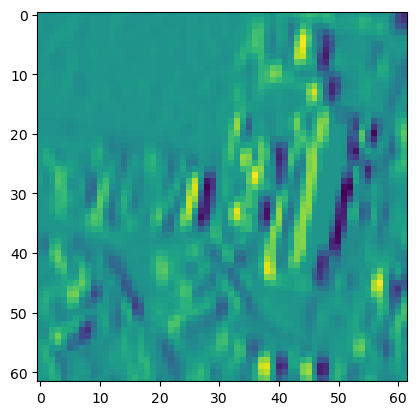

In [31]:
# Oplossing

plt.rcParams["savefig.bbox"] = 'tight'

plt.imshow(np.squeeze(industrialFiltered.detach()))

**Herhaal bovenstaande stappen voor een Forest Image uit de EuroSAT Dataset**

### Reflectie

Zijn 'Industrial_1.jpg' en 'Forrest_1.jpg' na een convolutie beter te onderscheiden?

**Extra: varieer de stride en de padding en toon de resultaten**

### Bronnen

[EuroSAT project](https://github.com/phelber/eurosat)

[Pytorch Neural Nets](https://pytorch.org/docs/stable/nn.html)

[Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing))

[A simple CNN with Pytorch](https://tomroth.com.au/pytorch-cnn)

[A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf)

[Using Dropout Regularization in PyTorch Models](https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models)